# **1. 데이터 로드 및 전처리**

Train data size: 13735
Test data size: 5887
x_train shape: (342, 80, 3)
x_test shape: (146, 80, 3)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                   ┃ Output Shape            ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)              │ (None, 70, 50)          │        1,700 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ max_pooling1d_8 (MaxPooling1D) │ (None, 35, 50)          │            0 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ batch_normalization_4          │ (None, 35, 50)          │          200 │
│ (BatchNormalization)           │                         │              │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ conv1d_9 (Conv1D)              │ (None, 31, 5)           │        1,255 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ max_pooling1d_9 (MaxPooling1D) │ (None, 15, 5)           │            0 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ dropout_4 (Dropout)            │ (None, 15, 5)           │            0 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ flatten_4 (Flatten)            │ (None, 75)              │            0 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ dense_4 (Dense)                │ (None, 5)               │          380 │
└────────────────────────────────┴─────────────────────────┴──────────────┘

 Total params: 3,535 (13.81 KB)

 Trainable params: 3,435 (13.42 KB)

 Non-trainable params: 100 (400.00 B)

Epoch 1/100
1/1 - 2s - 2s/step - accuracy: 0.1871 - loss: 3.4302 - val_accuracy: 0.0753 - val_loss: 2.7850
Epoch 2/100
1/1 - 0s - 85ms/step - accuracy: 0.2749 - loss: 2.8421 - val_accuracy: 0.0890 - val_loss: 2.7017
Epoch 3/100
1/1 - 0s - 85ms/step - accuracy: 0.3567 - loss: 2.4538 - val_accuracy: 0.0685 - val_loss: 2.6356
Epoch 4/100
1/1 - 0s - 83ms/step - accuracy: 0.3889 - loss: 2.3412 - val_accuracy: 0.0685 - val_loss: 2.5753
Epoch 5/100
1/1 - 0s - 72ms/step - accuracy: 0.5263 - loss: 2.0450 - val_accuracy: 0.0753 - val_loss: 2.5401
Epoch 6/100
1/1 - 0s - 71ms/step - accuracy: 0.5058 - loss: 1.9816 - val_accuracy: 0.0685 - val_loss: 2.5037
Epoch 7/100
1/1 - 0s - 84ms/step - accuracy: 0.5526 - loss: 1.9470 - val_accuracy: 0.0753 - val_loss: 2.4733
Epoch 8/100
1/1 - 0s - 76ms/step - accuracy: 0.5906 - loss: 1.8549 - val_accuracy: 0.0822 - val_loss: 2.4456
Epoch 9/100
1/1 - 0s - 85ms/step - accuracy: 0.6754 - loss: 1.7308 - val_accuracy: 0.0959 - val_loss: 2.4317
Epoch 10/100
1/1 - 0s

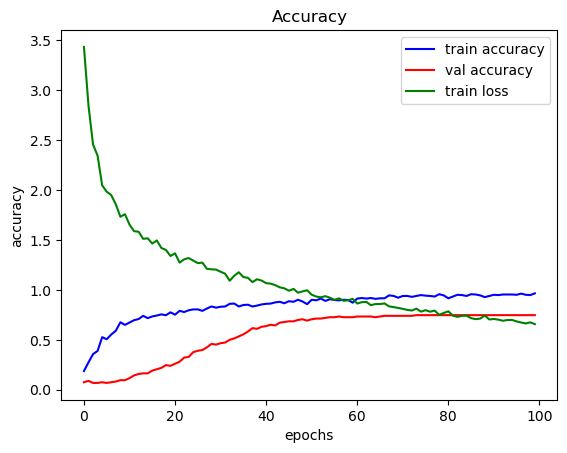

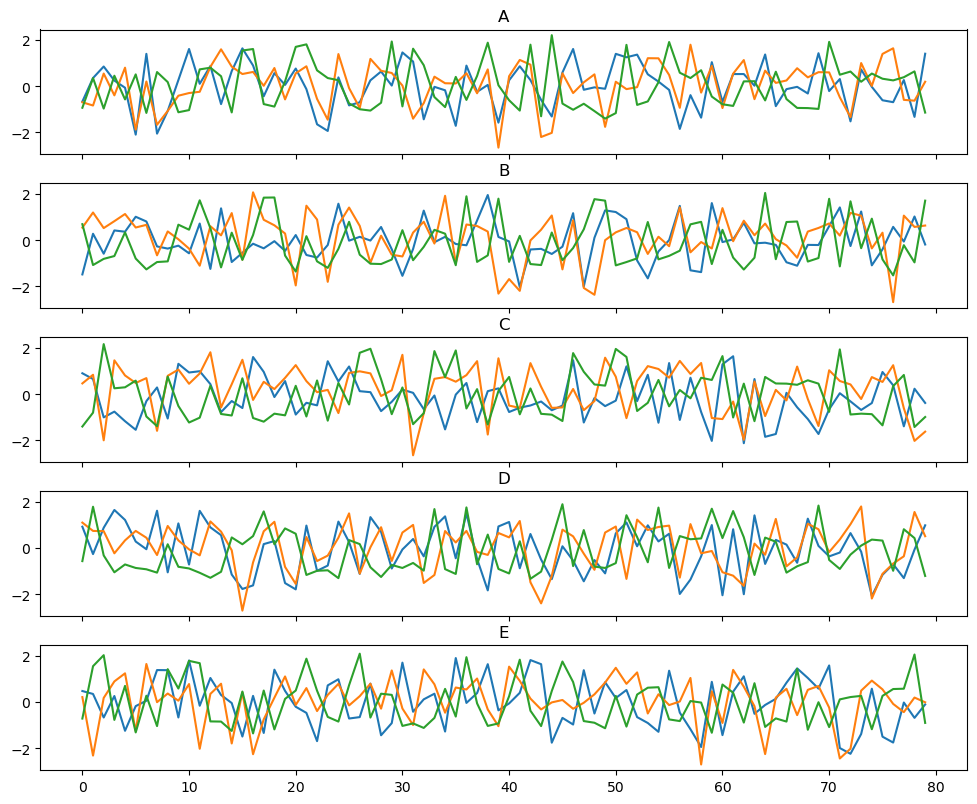

In [16]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers

# 데이터 로드
data = pd.read_csv('./원본 데이터/transformed_train.csv')

# 라벨 인코딩
label_encoder = LabelEncoder()
data['activity'] = label_encoder.fit_transform(data['activity'])

# 데이터 정규화
mean = np.mean(data[['x-accl', 'y-accl', 'z-accl']], axis=0)
std = np.std(data[['x-accl', 'y-accl', 'z-accl']], axis=0)
data[['x-accl', 'y-accl', 'z-accl']] = (data[['x-accl', 'y-accl', 'z-accl']] - mean) / std

# 데이터 분할 (7:3 비율로 train/test 분할)
train_data, test_data = train_test_split(data, 
                                         test_size=0.3, 
                                         random_state=42, 
                                         stratify=data['activity'])

# 데이터 분할이 올바르게 되었는지 확인
print(f"Train data size: {len(train_data)}")
print(f"Test data size: {len(test_data)}")

# 데이터 세그먼트화 및 라벨링 함수 (-1, TIME_PERIODS, 3)
TIME_PERIODS = 80  # 세그먼트 길이
STEP_DISTANCE = 40 # if STEP_DISTANCE = TIME_PERIODS, then no overlap

def data_segments(data):
    segments = []
    labels = []
    for i in range(0, len(data) - TIME_PERIODS, STEP_DISTANCE):
        X = data.iloc[i:i + TIME_PERIODS, 2:].values.tolist()  # x, y, z

        # 세그먼트 내 가장 빈번한 활동으로 라벨링
        values, counts = np.unique(data.iloc[i:i + TIME_PERIODS, 1], return_counts=True)
        label = values[np.argmax(counts)]

        segments.append(X)
        labels.append(label)

    if len(segments) == 0:
        raise ValueError("No segments were created. Check the data segmentation logic or the size of your data.")

    # reshape (-1, TIME_PERIODS, 3)
    segments = np.array(segments, dtype=np.float32).reshape(-1, TIME_PERIODS, 3)
    labels = np.asarray(labels)
    return segments, labels

# 훈련 및 테스트 데이터 세그먼트화
x_train, y_train = data_segments(train_data)
x_test, y_test = data_segments(test_data)

# 세그먼트 생성 후 데이터 크기 확인
print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")

# 라벨 원-핫 인코딩
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

# 1D CNN 모델 생성 (L2 정규화 적용)
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(TIME_PERIODS, 3)),  # shape=(80,3)
    tf.keras.layers.Conv1D(filters=50, kernel_size=11, activation='relu',
                           kernel_regularizer=regularizers.l2(0.03)),
    tf.keras.layers.MaxPool1D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(filters=5, kernel_size=5, activation='relu',
                           kernel_regularizer=regularizers.l2(0.03)),
    tf.keras.layers.MaxPool1D(),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=5, activation='softmax',
                          kernel_regularizer=regularizers.l2(0.03))
])

model.summary()

# 모델 컴파일 및 학습
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
ret = model.fit(x_train, y_train, epochs=100, batch_size=400, validation_data=(x_test, y_test), verbose=2)

# 모델 평가
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=2)
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

# 정확도 및 손실 시각화
plt.title("Accuracy")
plt.plot(ret.history['accuracy'], "b-", label="train accuracy")
plt.plot(ret.history['val_accuracy'], "r-", label="val accuracy")
plt.plot(ret.history['loss'], "g-", label="train loss")
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(loc="best")
plt.show()

# 샘플 활동 데이터 시각화
activity_labels = label_encoder.classes_  # activity names
train_labels = np.argmax(y_train, axis=1)

plot_data_indices = []
n = 1  # nth data point to plot

for i in range(5):  # for each class/activity
    plot_data_indices.append(np.where(train_labels == i)[0][n])  # get nth index for class

fig, ax = plt.subplots(5, sharex=True, sharey=True, figsize=(10, 8))
fig.tight_layout()

for i in range(5):
    k = plot_data_indices[i]
    ax[i].plot(x_train[k])
    ax[i].set_title(activity_labels[i])

plt.show()